# Dip Adjust ECM

This script creates a dip-adjusted ECM record. I plan to expand it further to also enable dip-adjustment of CFA records.

## Basic Setup


In [1]:
# import packages

# general
import numpy as np
import pandas as pd

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# my functions/classes
import sys
sys.path.append("../ecm_core_scripts/")
from ECMclass import ECM

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# set filepaths
path_to_data = "../../data/ecm/ecm_datafiles/"
path_to_angles = "../../data/ecm/ecm_angles/"
path_to_cuts = "../../data/cut_data/"
path_to_figures = "../../figures/ecm_diagnostic/"
metadata_file = 'metadata.csv'


This is super important! Here I set where to corner of the ALHIC2302 and ALHIC2201 cuts are relative to the center

In [3]:
# Set corner offsets
alhic2201_x_corner = 40  # in mm
alhic2201_y_corner = -20  # in mm
alhic2302_x_corner = -40  # in mm
alhic2302_y_corner = 20  # in mm

In [4]:
# make colormap
my_cmap = matplotlib.colormaps['Spectral']

## Import data

In [5]:
if True:

    # Import ECM Data
    meta = pd.read_csv(path_to_data+metadata_file)

    # set smoothing window
    window = 10

    # import each script as an ECM class item
    alhic2201_data = []
    alhic2302_data = []
    for index,row in meta.iterrows():
        
        core = row['core']
        section = row['section']
        face = row['face']
        ACorDC = row['ACorDC']
        
        print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
        
        data_item = ECM(core,section,face,ACorDC)
        data_item.rem_ends(10)
        data_item.smooth(window)
        data_item.section = str(data_item.section).replace('_', '.')

        if core == 'ALHIC2302' or core == 'alhic2302':
            alhic2302_data.append(data_item)
        elif core == 'ALHIC2201' or core == 'alhic2201':
            alhic2201_data.append(data_item)
        else:
            print("Core not recognized")

    # make a list of the sections in each core. Ensure each list contains no duplicates
    alhic2201_sections = []
    alhic2302_sections = []
    for item in alhic2201_data:
        alhic2201_sections.append(item.section)
    for item in alhic2302_data:
        alhic2302_sections.append(item.section)
    alhic2201_sections = list(set(alhic2201_sections))
    alhic2302_sections = list(set(alhic2302_sections))

Reading alhic2201, section 10_1-r-AC
Reading alhic2201, section 10_1-r-DC
Reading alhic2201, section 10_1-t-AC
Reading alhic2201, section 10_1-t-DC
Reading alhic2201, section 11_1-r-AC
Reading alhic2201, section 11_1-r-DC
Reading alhic2201, section 11_1-t-AC
Reading alhic2201, section 11_1-t-DC
Reading alhic2201, section 12_1-r-AC
Reading alhic2201, section 12_1-r-DC
Reading alhic2201, section 12_1-t-AC
Reading alhic2201, section 12_1-t-DC
Reading alhic2201, section 13_1-r-AC
Reading alhic2201, section 13_1-r-DC
Reading alhic2201, section 13_1-t-AC
Reading alhic2201, section 13_1-t-DC
Reading alhic2201, section 14_1-r-AC
Reading alhic2201, section 14_1-r-DC
Reading alhic2201, section 14_1-t-AC
Reading alhic2201, section 14_1-t-DC
Reading alhic2201, section 15_1-r-AC
Reading alhic2201, section 15_1-r-DC
Reading alhic2201, section 15_1-t-AC
Reading alhic2201, section 15_1-t-DC
Reading alhic2201, section 16_1-r-AC
Reading alhic2201, section 16_1-r-DC
Reading alhic2201, section 16_1-t-AC
R

In [6]:
# Import angle data
alhic2302_angles = pd.read_csv(path_to_angles+'alhic2302_median_dip.csv')
alhic2201_angles = pd.read_csv(path_to_angles+'alhic2201_median_dip.csv')

In [7]:
# load cut data
alhic2302_cutdata = pd.read_excel(path_to_cuts + 'alhic2302-cut_data.xlsx')
alhic2201_cutdata = pd.read_excel(path_to_cuts + 'alhic2201-cut_data.xlsx')

# combine both dfs on section
alhic2302_cutdata['section'] = alhic2302_cutdata['section'].astype(str)
alhic2302_angles['section'] = alhic2302_angles['section'].astype(str)
alhic2302_angles = pd.merge(alhic2302_cutdata, alhic2302_angles, on='section', how='outer')
alhic2201_cutdata['section'] = alhic2201_cutdata['section'].astype(str)
alhic2201_angles['section'] = alhic2201_angles['section'].astype(str)
alhic2201_angles = pd.merge(alhic2201_cutdata, alhic2201_angles, on='section', how='outer')

## Now calculate average dip and dip direction for each section

Here we leverage the fact that sections between points where the orientation is lost are probably consistent.

In [8]:
def get_avg_dip_between_lost(angles,core):

    """
    Calculate average dip and dip direction between 'oline_lost' True indices.
    
    Parameters:
    angles (DataFrame): DataFrame containing 'oline_lost', 'dip', 'dip_direction', and 'depth' columns.
    
    Returns:
    List of dictionaries with average dip, dip direction, top depth, and bottom depth for each segment.
    """

    # Find indices where 'oline_lost?' is True
    lost_indices = angles.index[angles['oline_lost'] == True].tolist()

    # append the first if not already included and sort 
    if 0 not in lost_indices:
        lost_indices = [0] + lost_indices

    # Prepare to store results
    avg_results = []

    # Loop through each segment between lost indices
    for i in range(len(lost_indices)):

        # set bounds of range
        start = lost_indices[i]

        # last segment is special case - goes to end of df
        if i == len(lost_indices) - 1:
            segment = angles.iloc[start:]
            
        # otherwise, go to next lost index
        else:
            end = lost_indices[i + 1]
            segment = angles.iloc[start:(end)]

        # get start and end section numbers        
        start_section = segment['section'].iloc[0]
        end_section = segment['section'].iloc[-1]

        # Only consider rows with valid dip and dip_direction
        valid_segment = segment.dropna(subset=['dip', 'dip_direction'])

        # only consider rows where flag_uncertainty is False
        valid_segment = valid_segment[valid_segment['flag_uncertainty'] == False]

        # if not empty, compute average dip and dip direction
        if not valid_segment.empty:

            avg_dip = valid_segment['dip'].median() #.mean()
            avg_dip_direction = valid_segment['dip_direction'].median()
        
        else:
            avg_dip = 0
            avg_dip_direction = 0


        if core == 'ALHIC2201':
            # compute aparent dip on each plane
            top_angle  = - np.arctan(np.tan(np.radians(avg_dip)) * np.sin(np.radians(avg_dip_direction))) * (180/np.pi)
            right_angle = - np.arctan(np.tan(np.radians(avg_dip)) * np.cos(np.radians(avg_dip_direction))) * (180/np.pi)
            
            # Store results
            avg_results.append({
                'start_section': start_section,
                'end_section': end_section,
                'avg_dip': avg_dip,
                'avg_dip_direction': avg_dip_direction,
                'top_angle': top_angle,
                'right_angle': right_angle,
            })
            
        else:

            # compute aparent dip on each plane
            top_angle  = np.arctan(np.tan(np.radians(avg_dip)) * np.sin(np.radians(avg_dip_direction))) * (180/np.pi)
            left_angle = -np.arctan(np.tan(np.radians(avg_dip)) * np.cos(np.radians(avg_dip_direction))) * (180/np.pi)
            
            # Store results
            avg_results.append({
                'start_section': start_section,
                'end_section': end_section,
                'avg_dip': avg_dip,
                'avg_dip_direction': avg_dip_direction,
                'top_angle': top_angle,
                'left_angle': left_angle,
            })

    return(avg_results)
    
alhic2201_avg = get_avg_dip_between_lost(alhic2201_angles,'ALHIC2201')
alhic2302_avg = get_avg_dip_between_lost(alhic2302_angles,'ALHIC2302')

for res in alhic2201_avg:
    print(res)
for res in alhic2302_avg:
    print(res)

{'start_section': '1.1', 'end_section': '19.1', 'avg_dip': 32.780992315, 'avg_dip_direction': 216.70874320000001, 'top_angle': 21.05377991807925, 'right_angle': 27.30613208299667}
{'start_section': '20.1', 'end_section': '20.1', 'avg_dip': 19.97060498, 'avg_dip_direction': 208.2961434, 'top_angle': 9.77368610989465, 'right_angle': 17.742991726190812}
{'start_section': '21.1', 'end_section': '27.1', 'avg_dip': 26.45416436, 'avg_dip_direction': 72.00384257, 'top_angle': -25.325386008510584, 'right_angle': -8.739656142711247}
{'start_section': '28.1', 'end_section': '21.2', 'avg_dip': 26.71622657, 'avg_dip_direction': 72.68910791, 'top_angle': -25.664519094074695, 'right_angle': -8.517365246863946}
{'start_section': '1.0', 'end_section': '11.0', 'avg_dip': 0, 'avg_dip_direction': 0, 'top_angle': 0.0, 'left_angle': -0.0}
{'start_section': '12.0', 'end_section': '21.0', 'avg_dip': 72.840699895, 'avg_dip_direction': 336.63427155, 'top_angle': -52.097330752139996, 'left_angle': -71.4092499923

In [9]:
def get_angles_per_section(angles, core):
    """
    Compute top/left/right apparent angles per section (no averaging across sections).
    Returns list of dicts formatted like alhic2201_avg / alhic2302_avg where
    start_section == end_section for each row.
    """
    results = []
    for _, row in angles.iterrows():
        sec = str(row['section'])
        # require valid dip & dip_direction and flag_uncertainty == False (to match previous logic)
        has_vals = pd.notna(row.get('dip')) and pd.notna(row.get('dip_direction'))
        flag_ok = ('flag_uncertainty' in angles.columns) and (row.get('flag_uncertainty') == False)
        if has_vals and flag_ok:
            avg_dip = float(row['dip'])
            avg_dip_direction = float(row['dip_direction'])
        else:
            avg_dip = 0.0
            avg_dip_direction = 0.0

        if core == 'ALHIC2201':
            top_angle  = - np.arctan(np.tan(np.radians(avg_dip)) * np.sin(np.radians(avg_dip_direction))) * (180/np.pi)
            right_angle = - np.arctan(np.tan(np.radians(avg_dip)) * np.cos(np.radians(avg_dip_direction))) * (180/np.pi)
            results.append({
                'start_section': sec,
                'end_section': sec,
                'avg_dip': avg_dip,
                'avg_dip_direction': avg_dip_direction,
                'top_angle': top_angle,
                'right_angle': right_angle,
            })
        else:
            top_angle  = np.arctan(np.tan(np.radians(avg_dip)) * np.sin(np.radians(avg_dip_direction))) * (180/np.pi)
            left_angle = -np.arctan(np.tan(np.radians(avg_dip)) * np.cos(np.radians(avg_dip_direction))) * (180/np.pi)
            results.append({
                'start_section': sec,
                'end_section': sec,
                'avg_dip': avg_dip,
                'avg_dip_direction': avg_dip_direction,
                'top_angle': top_angle,
                'left_angle': left_angle,
            })
    return results

# compute per-section angle dictionaries
alhic2201_individual = get_angles_per_section(alhic2201_angles, 'ALHIC2201')
alhic2302_individual = get_angles_per_section(alhic2302_angles, 'ALHIC2302')

# quick check (print first 5 of each)
print("ALHIC2201 (first 5):", alhic2201_individual[:5])
print("ALHIC2302 (first 5):", alhic2302_individual[:5])

ALHIC2201 (first 5): [{'start_section': '1.1', 'end_section': '1.1', 'avg_dip': 0.0, 'avg_dip_direction': 0.0, 'top_angle': -0.0, 'right_angle': -0.0}, {'start_section': '2.1', 'end_section': '2.1', 'avg_dip': 0.0, 'avg_dip_direction': 0.0, 'top_angle': -0.0, 'right_angle': -0.0}, {'start_section': '4.2', 'end_section': '4.2', 'avg_dip': 0.0, 'avg_dip_direction': 0.0, 'top_angle': -0.0, 'right_angle': -0.0}, {'start_section': '5.1', 'end_section': '5.1', 'avg_dip': 0.0, 'avg_dip_direction': 0.0, 'top_angle': -0.0, 'right_angle': -0.0}, {'start_section': '7.1', 'end_section': '7.1', 'avg_dip': 35.09782674, 'avg_dip_direction': 226.5360909, 'top_angle': 27.02454408423112, 'right_angle': 25.8002140295737}]
ALHIC2302 (first 5): [{'start_section': '1.0', 'end_section': '1.0', 'avg_dip': 0.0, 'avg_dip_direction': 0.0, 'top_angle': 0.0, 'left_angle': -0.0}, {'start_section': '2.0', 'end_section': '2.0', 'avg_dip': 0.0, 'avg_dip_direction': 0.0, 'top_angle': 0.0, 'left_angle': -0.0}, {'start_s

In [10]:
alhic2302_avg

[{'start_section': '1.0',
  'end_section': '11.0',
  'avg_dip': 0,
  'avg_dip_direction': 0,
  'top_angle': 0.0,
  'left_angle': -0.0},
 {'start_section': '12.0',
  'end_section': '21.0',
  'avg_dip': 72.840699895,
  'avg_dip_direction': 336.63427155,
  'top_angle': -52.097330752139996,
  'left_angle': -71.40924999231619},
 {'start_section': '22.0',
  'end_section': '22.0',
  'avg_dip': 0,
  'avg_dip_direction': 0,
  'top_angle': 0.0,
  'left_angle': -0.0},
 {'start_section': '23.0',
  'end_section': '26.0',
  'avg_dip': 71.77919902,
  'avg_dip_direction': 16.55178367,
  'top_angle': 40.87336803922474,
  'left_angle': -71.04671602484258},
 {'start_section': '27.0',
  'end_section': '32.0',
  'avg_dip': 66.74782042,
  'avg_dip_direction': 106.0922464,
  'top_angle': 65.90571947091632,
  'left_angle': 32.82594249165477},
 {'start_section': '33.0',
  'end_section': '33.0',
  'avg_dip': 65.47568791,
  'avg_dip_direction': 89.36299525,
  'top_angle': 65.47435063588573,
  'left_angle': -1.39

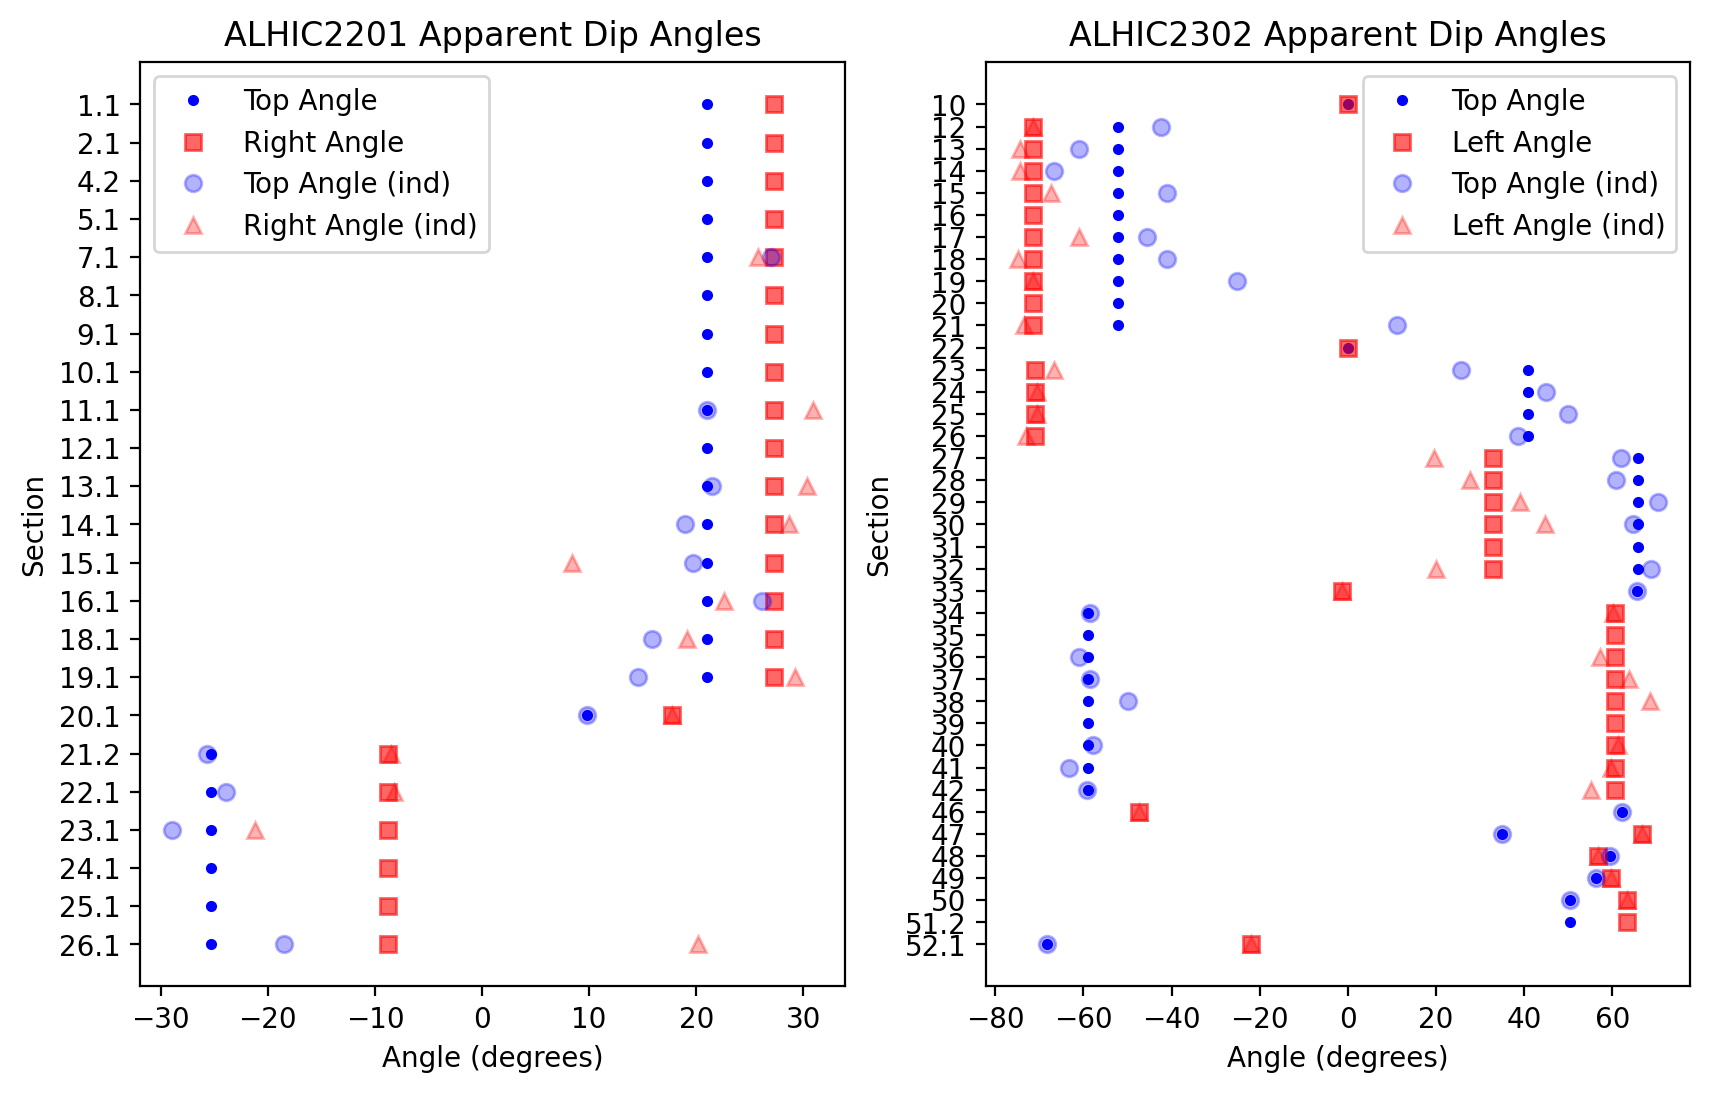

In [11]:
# sort section lists
alhic2302_sections = sorted(alhic2302_sections, key=lambda x: float(x))
alhic2201_sections = sorted(alhic2201_sections, key=lambda x: float(x))

# loop through sections of ALHIC2302 and find the corresponding average dip and dip direction
alhic2302_top_angle = []
alhic2302_left_angle = []
alhic2302_top_angle_ind = []
alhic2302_left_angle_ind = []
for sec in alhic2302_sections:
    # find average dip and dip direction for this section
    avg_dip = 0
    avg_dip_direction = 0
    avg_top_angle = 0
    avg_left_angle = 0
    for res in alhic2302_avg:
        if float(res['start_section']) <= float(sec) <= float(res['end_section']):
            avg_dip = res['avg_dip']
            avg_dip_direction = res['avg_dip_direction']
            avg_top_angle = res['top_angle']
            avg_left_angle = res['left_angle']
            break
    for r in alhic2302_individual:
        if float(r['start_section']) <= float(sec) <= float(r['end_section']):
            if r['top_angle']!=0:
                top_angle = r['top_angle']
                left_angle = r['left_angle']
            else:
                top_angle = np.nan
                left_angle = np.nan
            break
    alhic2302_top_angle.append(avg_top_angle)
    alhic2302_left_angle.append(avg_left_angle)
    alhic2302_top_angle_ind.append(top_angle)
    alhic2302_left_angle_ind.append(left_angle)
    

# now repeat for ALHIC2201
alhic2201_top_angle = []
alhic2201_right_angle = []
alhic2201_top_angle_ind = []
alhic2201_right_angle_ind = []
for sec in alhic2201_sections:
    # find average dip and dip direction for this section
    avg_dip = 0
    avg_dip_direction = 0
    avg_top_angle = 0
    avg_left_angle = 0
    for res in alhic2201_avg:
        if float(res['start_section']) <= float(sec) <= float(res['end_section']):
            avg_dip = res['avg_dip']
            avg_dip_direction = res['avg_dip_direction']
            avg_top_angle = res['top_angle']
            avg_right_angle = res['right_angle']
            break
    for r in alhic2201_individual:
        if float(r['start_section']) <= float(sec) <= float(r['end_section']):
            if r['top_angle']!=0:
                top_angle = r['top_angle']
                right_angle = r['right_angle']
            else:
                top_angle = np.nan
                right_angle = np.nan
            break
            
    alhic2201_top_angle.append(avg_top_angle)
    alhic2201_right_angle.append(avg_right_angle)
    alhic2201_top_angle_ind.append(top_angle)
    alhic2201_right_angle_ind.append(right_angle)


if True:
    # Make a plot showing left, right, and top angles over depth fore each core
    fig, ax = plt.subplots(1,2,figsize=(10,6),dpi=200)
    ax[0].plot(alhic2201_top_angle,alhic2201_sections,'b.',label='Top Angle')
    ax[0].plot(alhic2201_right_angle,alhic2201_sections,'rs',label='Right Angle',alpha = 0.6)
    ax[0].plot(alhic2201_top_angle_ind,alhic2201_sections,'bo',label='Top Angle (ind)',alpha = 0.3)
    ax[0].plot(alhic2201_right_angle_ind,alhic2201_sections,'r^',label='Right Angle (ind)',alpha = 0.3)
    ax[0].set_title('ALHIC2201 Apparent Dip Angles')
    ax[0].set_xlabel('Angle (degrees)')
    ax[0].set_ylabel('Section')
    ax[0].legend()
    ax[0].invert_yaxis()

    ax[1].plot(alhic2302_top_angle,alhic2302_sections,'b.',label='Top Angle')
    ax[1].plot(alhic2302_left_angle,alhic2302_sections,'rs',label='Left Angle',alpha = 0.6)
    ax[1].plot(alhic2302_top_angle_ind,alhic2302_sections,'bo',label='Top Angle (ind)',alpha = 0.3)
    ax[1].plot(alhic2302_left_angle_ind,alhic2302_sections,'r^',label='Left Angle (ind)',alpha = 0.3)
    ax[1].set_title('ALHIC2302 Apparent Dip Angles')
    ax[1].set_xlabel('Angle (degrees)')
    ax[1].set_ylabel('Section')
    ax[1].legend()  
    ax[1].invert_yaxis()

## Now let's make plots of shifted ALHIC2201 and ALHIC2302 data

Starting with ALHIC2201

In [12]:
def plotquarter(y_vec,ycor,d,meas,button,axs,rescale,shift_const = 0,shift_y_angle = 0):

    res = 0.008

    width = y_vec[1] - y_vec[0]

    d = d + shift_const

    for y in y_vec:

        idx = ycor==y
        tmeas = meas[idx]
        tbut = button[idx]
        td = d[idx]

        if shift_y_angle != 0:

            shift_y = y/1000 * np.tan(np.radians(shift_y_angle))
            td = td + shift_y

        #down"sample ECM to save plotting time (as needed)
        if res != 0:
            int_lo = round(min(td),2)
            int_hi = round(max(td),2)
            depth_interp = np.linspace(int_lo,int_hi,int((int_hi-int_lo)/res)+1)
            meas_interp = np.interp(depth_interp,np.flip(td),np.flip(tmeas))
            but_interp = np.interp(depth_interp,np.flip(td),np.flip(tbut))
            td = depth_interp
            tmeas = meas_interp
            tbut = np.round(but_interp)

        for i in range(len(tmeas)-1):
            if tbut[i] == 0:
                axs.add_patch(Rectangle((y-(width-0.2)/2,td[i]),(width-0.2),td[i+1]-td[i],facecolor=my_cmap(rescale(tmeas[i]))))
            else:
                axs.add_patch(Rectangle((y-(width-0.2)/2,td[i]),(width-0.2),td[i+1]-td[i],facecolor='k'))
    return()


In [13]:
# ALHIC2201 

# loop through sections
for sec in alhic2201_sections:
    
    # print update
    print("Running Section "+sec)
    
    # set data to empty
    AC_t = None
    AC_r = None
    DC_t = None
    DC_r = None
    #loop through data 
    for d in alhic2201_data:
        
        if d.section==sec:
            if d.ACorDC == 'AC':
                if d.face == 't':
                    AC_t = d
                if d.face == 'r':
                    AC_r = d                    
            else:
                if d.face == 't':
                    DC_t = d
                if d.face == 'r':
                    DC_r = d
    
    # find depth max and minimum
    minvec = []
    maxvec = []
    AC_all = []
    DC_all = []
    for data_face in [AC_t,AC_r,DC_t,DC_r]:
        if data_face != None:
            minvec.append(min(data_face.depth))
            maxvec.append(max(data_face.depth))
            
            if data_face.ACorDC == 'AC':
                AC_all.extend(data_face.meas)
            else:
                DC_all.extend(data_face.meas)
    ACpltmin = np.percentile(AC_all,5)
    ACpltmax = np.percentile(AC_all,95)
    DCpltmin = np.percentile(DC_all,5)
    DCpltmax = np.percentile(DC_all,95)  
    ACrescale = lambda k: (k-ACpltmin) /  (ACpltmax-ACpltmin)
    DCrescale = lambda k: (k-DCpltmin) /  (DCpltmax-DCpltmin)
    dmin = min(minvec)
    dmax = max(maxvec)
       
    # make figure
    fig, ax = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 3,2, 2, 3]},figsize=(9,6),dpi=200)
    
    # right-specific
    for a in [ax[0],ax[3]]:
        #a.yaxis.tick_right()
        a.set_xlim([60, -20])
        
    # top specific
    for a in [ax[1],ax[4]]:
        a.yaxis.tick_right()
        a.yaxis.set_label_position("right")
        a.set_xlim([-20,120])
        
    # applies to all
    for a in [ax[0],ax[1],ax[3],ax[4]]:
        a.set_ylabel('Depth (m)')
        a.set_xlabel('Distance From Center (mm)',fontsize=6)
        a.set_ylim([dmax, dmin])
        
        
    for a,data_face in zip([ax[0],ax[1],ax[3],ax[4]],[AC_r,AC_t,DC_r,DC_t]):

        # find the top angle and right angle for this section
        top_angle = 0
        right_angle = 0
        for res in alhic2201_avg: # alhic2201_individual:
            if float(res['start_section']) <= float(sec) <= float(res['end_section']):
                top_angle = res['top_angle']
                right_angle = res['right_angle']
                break
        
        if data_face != None:

            if data_face.face == 'r':
                yall = data_face.y_s - data_face.y_left - alhic2201_y_corner
                yvec = data_face.y_vec - data_face.y_left - alhic2201_y_corner

                # set shift based on apparent dip angle
                shift_const = alhic2201_x_corner/1000 * np.tan(np.radians(top_angle))
                shift_y_angle = right_angle

            else:
                yall = data_face.y_right - data_face.y_s - alhic2201_x_corner
                yvec = data_face.y_right - data_face.y_vec - alhic2201_x_corner

                # set shift based on apparent dip angle
                shift_const = alhic2201_y_corner/1000 * np.tan(np.radians(right_angle))
                shift_y_angle = top_angle
            
            if data_face.ACorDC =='AC':
                rescale = ACrescale
            else:
                rescale = DCrescale
        
        
            # plot data
            plotquarter(yvec,
                        yall,
                        data_face.depth_s,
                        data_face.meas_s,
                        data_face.button_s,
                        a,
                        rescale,
                        shift_const,
                        shift_y_angle)
    
    # housekeeping
    fig.suptitle('ALHIC2201 - '+sec+' - '+str(window)+' mm smooth')
    ax[2].axis('off')
    ax[0].set_title('AC - Right')
    ax[1].set_title('AC - Top')
    ax[3].set_title('DC - Right')
    ax[4].set_title('DC - Top')
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0)

    # ad colorbar
    #fig.subplots_adjust(bottom=0.8)
    #    ACcbar_ax = fig.add_axes([0.08,-0.07,0.35,0.05])
    ACcbar_ax = fig.add_axes([0.07,-0.05,0.35,0.05])
    ACnorm = matplotlib.colors.Normalize(vmin=ACpltmin,vmax=ACpltmax)
    DCcbar_ax = fig.add_axes([0.58,-0.05,0.35,0.05])
    DCnorm = matplotlib.colors.Normalize(vmin=DCpltmin,vmax=DCpltmax)
    ACcbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=ACnorm, cmap=my_cmap),cax=ACcbar_ax,
                    orientation='horizontal',label='Current (amps)')
    DCcbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=DCnorm, cmap=my_cmap),cax=DCcbar_ax,
                    orientation='horizontal',label='Current (amps)')
    
    # save figure
    fname = path_to_figures +'ecm_unshifted/alhic2201-'+sec+'.png'
    fig.savefig(fname,bbox_inches='tight')
    plt.close(fig)
    

Running Section 1.1
Running Section 2.1
Running Section 4.2
Running Section 5.1
Running Section 7.1
Running Section 8.1
Running Section 9.1
Running Section 10.1
Running Section 11.1
Running Section 12.1
Running Section 13.1
Running Section 14.1
Running Section 15.1
Running Section 16.1
Running Section 18.1
Running Section 19.1
Running Section 20.1
Running Section 21.2
Running Section 22.1
Running Section 23.1
Running Section 24.1
Running Section 25.1
Running Section 26.1


In [14]:
# ALHIC2302

# loop through sections
for sec in alhic2302_sections:

    # print update
    print("Running Section "+sec)
    
    # set data to empty
    AC_t = None
    AC_l = None
    DC_t = None
    DC_l = None
    #loop through data 
    for d in alhic2302_data:
        if d.section==sec:
            if d.ACorDC == 'AC':
                if d.face == 't':
                    AC_t = d
                if d.face == 'l':
                    AC_l = d                    
            else:
                if d.face == 't':
                    DC_t = d
                if d.face == 'l':
                    DC_l = d
    
    # find depth max and minimum
    minvec = []
    maxvec = []
    AC_all = []
    DC_all = []
    for data_face in [AC_t,AC_l,DC_t,DC_l]:
        if data_face != None:
            minvec.append(min(data_face.depth))
            maxvec.append(max(data_face.depth))
            if data_face.ACorDC == 'AC':
                AC_all.extend(data_face.meas)
            else:
                DC_all.extend(data_face.meas)
    ACpltmin = np.percentile(AC_all,5)
    ACpltmax = np.percentile(AC_all,95)
    DCpltmin = np.percentile(DC_all,5)
    DCpltmax = np.percentile(DC_all,95)  
    ACrescale = lambda k: (k-ACpltmin) /  (ACpltmax-ACpltmin)
    DCrescale = lambda k: (k-DCpltmin) /  (DCpltmax-DCpltmin)
    dmin = min(minvec) - 0.2
    dmax = max(maxvec) + 0.2
    
   
    # make figure
    fig, ax = plt.subplots(1, 5, gridspec_kw={'width_ratios': [3, 3,2, 3, 3]},figsize=(9,6),dpi=200)
    
    # top-specific
    for a in [ax[0],ax[3]]:
        #a.yaxis.tick_right()
        a.set_xlim([120, -20])
        
    # right specific
    for a in [ax[1],ax[4]]:
        a.yaxis.tick_right()
        a.yaxis.set_label_position("right")
        a.set_xlim([-20,120])
        
    # applies to all
    for a in [ax[0],ax[1],ax[3],ax[4]]:
        a.set_ylabel('Depth (m)')
        a.set_xlabel('Distance From Center (mm)',fontsize=6)
        a.set_ylim([dmax, dmin])
        
        
    for a,data_face in zip([ax[1],ax[0],ax[4],ax[3]],[AC_l,AC_t,DC_l,DC_t]):

        # find the top angle and right angle for this section
        top_angle = 0
        left_angle = 0
        for res in alhic2302_avg:# alhic2302_individual:
            if float(res['start_section']) <= float(sec) <= float(res['end_section']):
                top_angle = res['top_angle']
                left_angle = res['left_angle']
                break
        
        if data_face != None:
            if data_face.face == 'l':
                yall = data_face.y_right - data_face.y_s - alhic2302_x_corner
                yvec = data_face.y_right -  data_face.y_vec - alhic2302_x_corner

                # set shift based on apparent dip angle
                shift_const = alhic2302_x_corner/1000 * np.tan(np.radians(top_angle))
                shift_y_angle = left_angle
                
            else:
                yall = data_face.y_s -  data_face.y_left - alhic2302_y_corner
                yvec =data_face.y_vec -  data_face.y_left - alhic2302_y_corner

                # set shift based on apparent dip angle
                shift_const = alhic2302_y_corner/1000 * np.tan(np.radians(left_angle))
                shift_y_angle = top_angle
            
            if data_face.ACorDC =='AC':
                rescale = ACrescale
            else:
                rescale = DCrescale
        
            # plot data
            plotquarter(yvec,
                        yall,
                        data_face.depth_s,
                        data_face.meas_s,
                        data_face.button_s,
                        a,
                        rescale,
                        shift_const,
                        shift_y_angle)
    
    # housekeeping
    fig.suptitle('ALHIC2302 - '+sec+' - '+str(window)+' mm smooth')
    ax[2].axis('off')
    ax[1].set_title('AC - Left')
    ax[0].set_title('AC - Top')
    ax[4].set_title('DC - Left')
    ax[3].set_title('DC - Top')
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0)

    # ad colorbar
    #fig.subplots_adjust(bottom=0.8)
    #    ACcbar_ax = fig.add_axes([0.08,-0.07,0.35,0.05])
    ACcbar_ax = fig.add_axes([0.07,-0.05,0.35,0.05])
    ACnorm = matplotlib.colors.Normalize(vmin=ACpltmin,vmax=ACpltmax)
    DCcbar_ax = fig.add_axes([0.58,-0.05,0.35,0.05])
    DCnorm = matplotlib.colors.Normalize(vmin=DCpltmin,vmax=DCpltmax)
    ACcbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=ACnorm, cmap=my_cmap),cax=ACcbar_ax,
                    orientation='horizontal',label='Current (amps)')
    DCcbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=DCnorm, cmap=my_cmap),cax=DCcbar_ax,
                    orientation='horizontal',label='Current (amps)')
    
    # save figure
    fname = path_to_figures +'ecm_unshifted/alhic2302-'+sec+'.png'
    fig.savefig(fname,bbox_inches='tight')
    plt.close(fig)

Running Section 10
Running Section 12
Running Section 13
Running Section 14
Running Section 15
Running Section 16
Running Section 17
Running Section 18
Running Section 19
Running Section 20
Running Section 21
Running Section 22
Running Section 23
Running Section 24
Running Section 25
Running Section 26
Running Section 27
Running Section 28
Running Section 29
Running Section 30
Running Section 31
Running Section 32
Running Section 33
Running Section 34
Running Section 35
Running Section 36
Running Section 37
Running Section 38
Running Section 39
Running Section 40
Running Section 41
Running Section 42
Running Section 46
Running Section 47
Running Section 48
Running Section 49
Running Section 50
Running Section 51.2
Running Section 52.1


## Save the ALHIC2302 dip angle data used for shifting to a single csv files



In [15]:

rows = []
for sec in alhic2302_sections:
    # find individual entry for this section
    indiv = next((r for r in alhic2302_individual if float(r['start_section']) <= float(sec) <= float(r['end_section'])), None)
    apar_ind = float(indiv['top_angle']) if (indiv is not None) else np.nan

    # find average entry that covers this section
    avg = next((r for r in alhic2302_avg if float(r['start_section']) <= float(sec) <= float(r['end_section'])), None)
    apar_avg = float(avg['top_angle']) if (avg is not None) else np.nan

    # make NaN if value is actually zero
    if np.isclose(apar_ind, 0.0):
        apar_ind = np.nan
    if np.isclose(apar_avg, 0.0):
        apar_avg = np.nan

    rows.append({'section': sec, 'aparent_dip': apar_ind, 'aparent_dip_ave': apar_avg})

out_df = pd.DataFrame(rows, columns=['section','aparent_dip','aparent_dip_ave'])

# save to CSV
out_fname =  'alhic2302_apparent_dip.csv'
out_df.to_csv(out_fname, index=False)
